In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

from IPython import display
from utils import Logger 

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

this is a file to help us visualize

In [ ]:
data_folder='./dataset/MNIST'

Preprocess the dataset

In [7]:
def mnist_data():
    compose=transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((.5,),(.5,))
    ])
    out_dir='/dataset'
    return datasets.FashionMNIST(root=out_dir,train=True,
                         transform=compose,download=True)

#Load data
data = mnist_data()

#Create loader with data, to iterate over it
data_loader=torch.utils.data.DataLoader(data,batch_size=100,shuffle=True)

#number of batches
num_batches=len(data_loader)

Extracting /dataset\FashionMNIST\raw\train-images-idx3-ubyte.gz to /dataset\FashionMNIST\raw


Extracting /dataset\FashionMNIST\raw\train-labels-idx1-ubyte.gz to /dataset\FashionMNIST\raw



Extracting /dataset\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to /dataset\FashionMNIST\raw


Extracting /dataset\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to /dataset\FashionMNIST\raw
Processing...


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


In [8]:
def Fmnist_data():
    compose=transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((.5,),(.5,))
    ])
    out_dir='/datasetF'
    #train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
    return datasets.FashionMNIST(root=out_dir,train=True,
                         transform=compose,download=True)

#Load data
data = Fmnist_data()

#Create loader with data, to iterate over it
data_loader=torch.utils.data.DataLoader(data,batch_size=100,shuffle=True)

#number of batches
num_batches=len(data_loader)

Extracting /datasetF\FashionMNIST\raw\train-images-idx3-ubyte.gz to /datasetF\FashionMNIST\raw



Extracting /datasetF\FashionMNIST\raw\train-labels-idx1-ubyte.gz to /datasetF\FashionMNIST\raw


Extracting /datasetF\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to /datasetF\FashionMNIST\raw


Extracting /datasetF\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to /datasetF\FashionMNIST\raw
Processing...
Done!


Define the neural networks, starting with the Discriminator. This network will take a flattened image as its input, and return the probability of it belonging to the real dataset, or the synthetic dataset. The input size for each image will be 28x28=784. Regarding the structure of this network, it will have three hidden layers, each followed by a Leaky-ReLU nonlinearity and a Dropout layer to prevent overfitting. A Sigmoid/Logistic function is applied to the real-valued output to obtain a value in the open-range (0, 1)

### My Networks

In [9]:
class DiscriminatorNet(torch.nn.Module):
    
    #3 hidden-layer discriminative nn
    
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features=784
        n_out=1
        
        self.hidden0=nn.Sequential(
            nn.Linear(n_features,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden1=nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden2=nn.Sequential(
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.out=nn.Sequential(
            torch.nn.Linear(256,n_out),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
        


In [10]:
def images_to_vectors(images):
    return images.view(images.size(0),784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0),1,28,28)

In [11]:
class GeneratorNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorNet,self).__init__()
        n_features=100
        n_out=784
        
        self.hidden0=nn.Sequential(
            nn.Linear(n_features,256),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden1=nn.Sequential(
            nn.Linear(256,512),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden2=nn.Sequential(
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.out=nn.Sequential(
            nn.Linear(1024,n_out),
            nn.Tanh()
        )
        
    
    def forward(self,x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    


In [12]:
def noise(size):
    #1-d vector of gaussian sampled random values
    
    n= Variable(torch.randn(size,100))
    #pass to the GPU
    if torch.cuda.is_available(): return n.cuda()
    return n

In [13]:
discriminator = DiscriminatorNet()
generator = GeneratorNet() 

if  torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

We also need some additional functionality that allows us to create the random noise. The random noise will be sampled from a normal distribution with mean 0 and variance 1

we’ll use Adam as the optimization algorithm for both neural networks

### Optimization

In [14]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

The loss function we’ll be using for this task is named Binary Cross Entopy Loss (BCE Loss), and it will be used for this scenario as it resembles the log-loss for both the Generator and Discriminator

In [15]:
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1

# Number of epochs
num_epochs = 200

In [16]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [17]:
def train_discriminator(optimizer , real_data , fake_data):
    
    N = real_data.size(0)
    
    #need to zero gradients
    optimizer.zero_grad()
    
    #train on real data
    prediction_real = discriminator(real_data)
    
    #calculate error and backpropagate
    error_real=loss(prediction_real,real_data_target(N))
    error_real.backward()
    
    #train on fake data
    prediction_fake=discriminator(fake_data)
    error_fake=loss(prediction_fake,fake_data_target(N))
    error_fake.backward()
    
    optimizer.step()
    
    #return error and prdictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake


def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

we want to visualize how the training process develops while our GAN learns. To do so, we will create a static batch of noise, every few steps we will visualize the batch of images the generator outputs when using this noise as input

In [18]:
num_test_samples=16
test_noise=noise(num_test_samples)

### Training

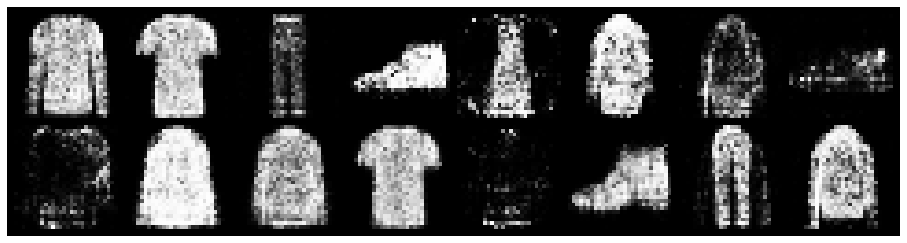

Epoch: [54/200], Batch Num: [400/600]
Discriminator Loss: 1.1407, Generator Loss: 1.0408
D(x): 0.6451, D(G(z)): 0.3786


In [ ]:
logger = Logger(model_name='VGAN', data_name='FMNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)